### **`Import Libraries`**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from keras.callbacks import EarlyStopping
from datetime import datetime
from google.colab import files
import tensorflow as tf
from tensorflow import keras

###**Function to plot basic series**

In [9]:
def plot_series(datelist ,series, format="-", start=0, end=None):
    plt.plot(datelist, series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.savefig('new.jpg')
    files.download('new.jpg') 
    plt.grid(True)


### Mount and View Data 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [4]:
dataset= pd.read_csv('gdrive/My Drive/HEROMOTOCO.csv')

In [5]:
 dataset

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HEROHONDA,EQ,1145.20,1200.00,1236.80,1171.00,1209.95,1207.60,1209.11,10631,1.285401e+12,NaN,NaN,NaN
1,2000-01-04,HEROHONDA,EQ,1207.60,1200.00,1220.00,1176.00,1200.00,1199.85,1200.93,19849,2.383719e+12,NaN,NaN,NaN
2,2000-01-05,HEROHONDA,EQ,1199.85,1155.00,1178.00,1140.00,1140.00,1143.80,1159.74,2525,2.928355e+11,NaN,NaN,NaN
3,2000-01-06,HEROHONDA,EQ,1143.80,1183.00,1189.95,1150.25,1165.00,1161.40,1167.29,4375,5.106887e+11,NaN,NaN,NaN
4,2000-01-07,HEROHONDA,EQ,1161.40,1140.00,1140.00,1069.00,1105.00,1106.55,1103.52,9093,1.003429e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5136,2020-08-25,HEROMOTOCO,EQ,3015.05,3044.00,3052.95,2957.85,2985.95,2969.75,3002.25,1324090,3.975243e+14,71119.0,397548.0,0.3002
5137,2020-08-26,HEROMOTOCO,EQ,2969.75,3110.00,3181.35,3070.00,3160.45,3160.75,3119.68,4651111,1.450998e+15,207879.0,792853.0,0.1705
5138,2020-08-27,HEROMOTOCO,EQ,3160.75,3159.00,3170.00,3107.50,3136.00,3141.75,3130.03,1431518,4.480691e+14,76057.0,230374.0,0.1609
5139,2020-08-28,HEROMOTOCO,EQ,3141.75,3119.05,3164.00,3050.65,3068.15,3059.30,3101.21,1838010,5.700058e+14,105935.0,525422.0,0.2859


In [7]:
datelist = list(dataset['Date'])
datelist = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

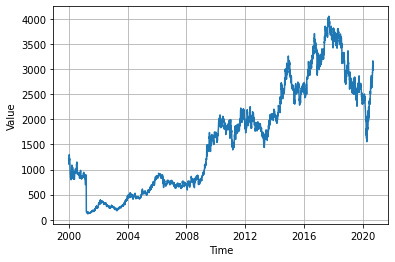

In [8]:
plot_series(datelist,dataset['Close']) ## I chose the closing price as the parameter I want to predict


### Spliting into Test and Train

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

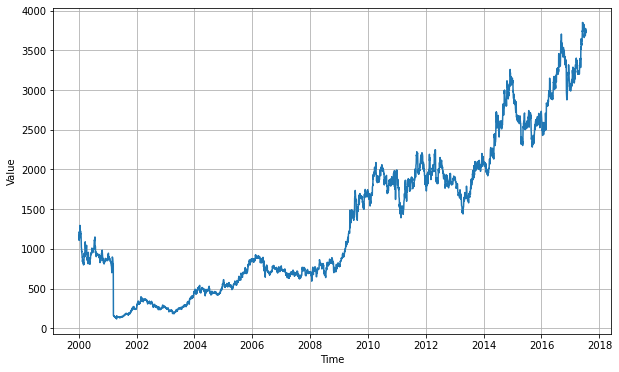

In [10]:
Train=dataset['Close']
time = np.array(range(len(Train)))
split_time = int(0.85*len(Train)) 
time_train = datelist[:split_time]
x_train = Train[:split_time]
time_valid = datelist[split_time:]
x_valid = Train[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

##Accuracy Metric

In [11]:
def accuracy(x_valid,prediction,retmetric=False):
 MAE=keras.metrics.mean_absolute_error(x_valid,prediction).numpy()
 MSE=keras.metrics.mean_squared_error(x_valid, prediction).numpy()
 print("MSE : ",keras.metrics.mean_squared_error(x_valid, prediction).numpy())
 print("MAE: " ,keras.metrics.mean_absolute_error(x_valid,prediction).numpy())
 if retmetric == True:
  return MAE
 

### Moving Average Function 

In [12]:
def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    sum=np.sum(series[time: (time + window_size)])
    mva=sum/window_size
    forecast.append(mva)
  return np.array(forecast)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MSE :  32488.284767128804
MAE:  143.39250809585494


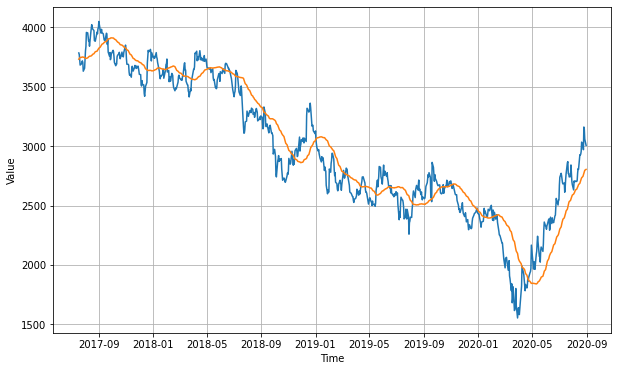

In [13]:
moving_avg = moving_average_forecast(Train, 40)[split_time - 40:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
accuracy(x_valid,moving_avg)

### Moving Average with a difference to account for a period in the series

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

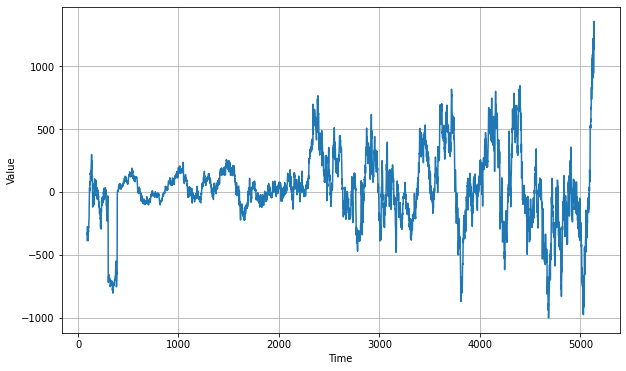

In [14]:
diff_series = (np.array(Train[90:]) - np.array(Train[:-90]))
diff_time = time[90:]
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

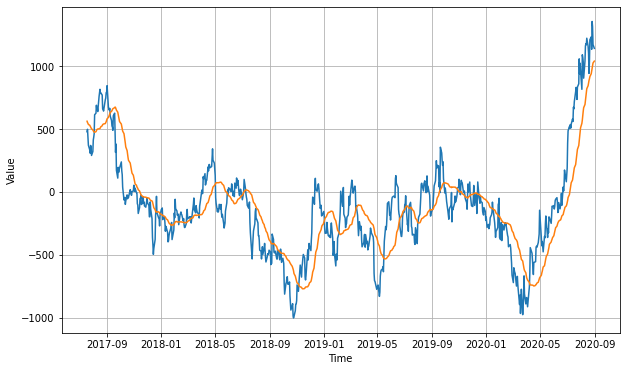

In [15]:
diff_moving_avg = moving_average_forecast(diff_series, 30)[split_time - 90 - 30:]  
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 90:])
plot_series(time_valid, diff_moving_avg)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

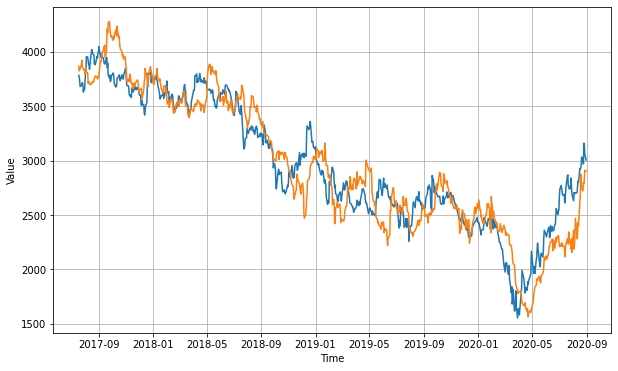

In [16]:
diff_moving_avg_plus_past = Train[split_time - 90:-90] + diff_moving_avg ## Adding Back the values
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [45]:
accuracy(x_valid,diff_moving_avg_plus_past)

MSE :  50870.05675660622
MAE:  180.29192573402415


###Smoothening the Training series while adding the Moving Avg

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

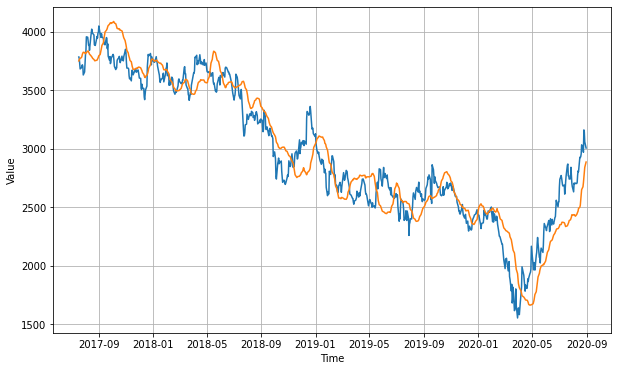

In [17]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(Train[split_time - 100:-90], 10) + diff_moving_avg #
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [18]:
accuracy(x_valid,diff_moving_avg_plus_smooth_past)

MSE :  37266.263702515105
MAE:  156.27618523316062


### Input pipeline

In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [20]:
window_size = 90
batch_size =  128
shuffle_buffer_size = len(x_train)

## Dense Network

In [21]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(500, activation="relu"), 
    tf.keras.layers.Dense(1)
])


#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    #lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=2 )

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Epoch 1/100
34/34 - 1s - loss: 2974227.0000
Epoch 2/100
34/34 - 1s - loss: 20562.8867
Epoch 3/100
34/34 - 1s - loss: 17795.5371
Epoch 4/100
34/34 - 1s - loss: 16079.6504
Epoch 5/100
34/34 - 1s - loss: 14287.2305
Epoch 6/100
34/34 - 1s - loss: 13174.5400
Epoch 7/100
34/34 - 1s - loss: 12310.3506
Epoch 8/100
34/34 - 1s - loss: 11244.4219
Epoch 9/100
34/34 - 1s - loss: 10447.3037
Epoch 10/100
34/34 - 1s - loss: 9441.2842
Epoch 11/100
34/34 - 1s - loss: 8891.5059
Epoch 12/100
34/34 - 1s - loss: 8323.8301
Epoch 13/100
34/34 - 1s - loss: 7897.1968
Epoch 14/100
34/34 - 1s - loss: 7604.4878
Epoch 15/100
34/34 - 1s - loss: 7207.4473
Epoch 16/100
34/34 - 1s - loss: 7233.5073
Epoch 17/100
34/34 - 1s - loss: 6762.0610
Epoch 18/100
34/34 - 1s - loss: 6431.2158
Epoch 19/100
34/34 - 1s - loss: 6251.7979
Epoch 20/100
34/34 - 1s - loss: 6182.1470
Epoch 21/100
34/34 - 1s - loss: 5795.1797
Epoch 22/100
34/34 - 1s - loss: 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

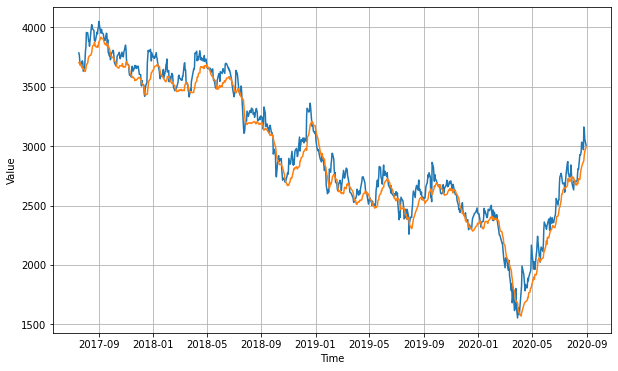

In [22]:
forecast = []
for time in range(len(Train) - window_size):
  forecast.append(model.predict(np.array(Train[time:time + window_size])[np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
accuracy(x_valid,results)

MSE :  11013.445
MAE:  82.419106


### LSTM

####Choosing a learning rate + Window_size + Batch Size

In [56]:
window_size = 90  # Hyperparams
batch_size =  128 # Hyperparams
shuffle_buffer_size = len(x_train)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(1000,activation="relu"),
   tf.keras.layers.Dense(500,activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 30000.0) 
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 5e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(dataset, epochs=100,verbose=2,callbacks=[lr_schedule])

Epoch 1/100
34/34 - 21s - loss: 924.8585 - mse: 1339514.2500
Epoch 2/100
34/34 - 15s - loss: 350.9736 - mse: 282064.8125
Epoch 3/100
34/34 - 15s - loss: 269.5466 - mse: 191270.4688
Epoch 4/100
34/34 - 15s - loss: 231.9640 - mse: 169734.7500
Epoch 5/100
34/34 - 15s - loss: 219.2324 - mse: 154779.3594
Epoch 6/100
34/34 - 15s - loss: 208.9357 - mse: 139786.8438
Epoch 7/100
34/34 - 15s - loss: 211.4149 - mse: 130449.8594
Epoch 8/100
34/34 - 15s - loss: 187.1312 - mse: 113586.2734
Epoch 9/100
34/34 - 16s - loss: 174.3430 - mse: 95785.3828
Epoch 10/100
34/34 - 15s - loss: 139.4210 - mse: 58673.3125
Epoch 11/100
34/34 - 15s - loss: 100.2103 - mse: 25007.1914
Epoch 12/100
34/34 - 15s - loss: 117.4115 - mse: 23931.0039
Epoch 13/100
34/34 - 15s - loss: 80.8909 - mse: 13993.5664
Epoch 14/100
34/34 - 15s - loss: 84.5790 - mse: 14131.1465
Epoch 15/100
34/34 - 15s - loss: 120.3119 - mse: 22653.6270
Epoch 16/100
34/34 - 15s - loss: 90.6708 - mse: 15032.7783
Epoch 17/100
34/34 - 15s - loss: 118.2351 -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

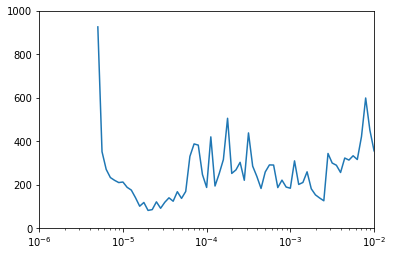

In [60]:

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-2, 0, 1000])
plt.savefig('learningrateZoomed.jpg')
files.download('learningrateZoomed.jpg') 

In [25]:
window_size = 90  # Hyperparams
batch_size =  256 # Hyperparams
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(1000,activation="relu"),
   tf.keras.layers.Dense(500,activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 30000.0) 
])
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
history = model.fit(dataset, epochs=500,verbose=2,callbacks=[es])

Epoch 1/500
17/17 - 21s - loss: 680.4171 - mse: 827405.0000
Epoch 2/500
17/17 - 15s - loss: 443.1716 - mse: 352000.9062
Epoch 3/500
17/17 - 15s - loss: 352.9641 - mse: 275327.5000
Epoch 4/500
17/17 - 15s - loss: 287.1051 - mse: 225067.3906
Epoch 5/500
17/17 - 15s - loss: 246.8557 - mse: 179211.2188
Epoch 6/500
17/17 - 15s - loss: 223.2064 - mse: 151225.0625
Epoch 7/500
17/17 - 15s - loss: 218.0968 - mse: 133977.8125
Epoch 8/500
17/17 - 15s - loss: 203.4279 - mse: 119013.6484
Epoch 9/500
17/17 - 15s - loss: 184.2057 - mse: 105005.8984
Epoch 10/500
17/17 - 15s - loss: 167.6025 - mse: 92567.2422
Epoch 11/500
17/17 - 15s - loss: 153.6857 - mse: 81160.1328
Epoch 12/500
17/17 - 15s - loss: 143.4387 - mse: 69162.8516
Epoch 13/500
17/17 - 15s - loss: 136.6824 - mse: 59376.7500
Epoch 14/500
17/17 - 15s - loss: 128.4357 - mse: 51632.9180
Epoch 15/500
17/17 - 15s - loss: 122.0295 - mse: 45074.5547
Epoch 16/500
17/17 - 15s - loss: 112.8469 - mse: 40156.8438
Epoch 17/500
17/17 - 15s - loss: 108.222

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

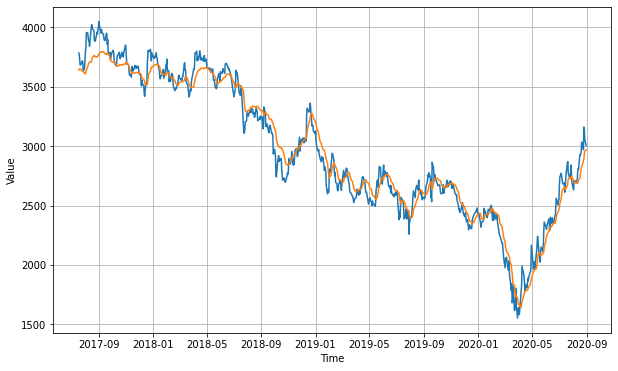

In [26]:

forecast = []
for time in range(len(Train) - window_size):
  forecast.append(model.predict(np.array(Train[time:time + window_size])[np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [27]:
accuracy(x_valid,results)

MSE :  10364.572
MAE:  80.46758
